<a href="https://colab.research.google.com/github/FaustoFLES/Programacion-Analitica/blob/main/Pr%C3%A1ctica_27_Clases_No_Balanceadas%2C_Evaluaci%C3%B3n_y_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📘 Tarea: Clasificación con SVM en un contexto de Clases No Balanceadas

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Nivel:** Maestría  
**Duración estimada:** 2-3 horas  
**Herramientas:** Python, Scikit-Learn, imbalanced-learn, Matplotlib, Google Colab  
**Temas clave:**  
- Clasificación con SVM  
- Clases no balanceadas  
- Validación cruzada estratificada  
- Métricas adaptadas a desbalance  
- SMOTE y otras técnicas de remuestreo


## 🧾 Objetivos de aprendizaje

Al finalizar esta tarea, el estudiante será capaz de:

- Identificar los efectos del desbalance de clases en modelos clasificadores.
- Implementar una SVM en un escenario multiclase o binario con fuerte desbalance.
- Evaluar el rendimiento del modelo usando métricas robustas como recall, F1, y G-mean.
- Aplicar técnicas como SMOTE y comparar su impacto.
- Utilizar `StratifiedKFold` para asegurar la adecuada evaluación del modelo.


## 🔧 Instrucciones

1. **Carga y exploración del dataset**
   - Utiliza el dataset `breast_cancer` o `wine` de Scikit-Learn.
   - Verifica la distribución de clases.
   - Visualiza con un gráfico la distribución y las principales características.

2. **Entrenamiento base con SVM**
   - Usa un modelo SVM con kernel RBF.
   - Aplica `StratifiedKFold` con 5 particiones.
   - Evalúa con métricas por clase: precisión, recall, F1-score.
   - Calcula y reporta métricas promedio y por clase.

3. **Análisis del problema de desbalance**
   - Interpreta las métricas: ¿qué clase tiene peor desempeño? ¿por qué?
   - Reporta matriz de confusión promedio.

4. **Aplicación de SMOTE**
   - Aplica `SMOTE` solo al conjunto de entrenamiento dentro de cada fold.
   - Entrena nuevamente la SVM.
   - Compara métricas antes y después.

5. **Visualización y conclusiones**
   - Usa un gráfico de barras comparando F1 por clase antes y después.
   - Comenta las ventajas y riesgos de aplicar SMOTE con SVM.
   - Explica cuándo conviene usar otras técnicas como `One-Sided Selection` o `ADASYN`.


## 📁 Entregables

- Google Colab Notebook con:
  - Código bien comentado
  - Gráficas solicitadas
  - Conclusiones reflexivas al final
- Exportación del notebook a PDF


In [2]:
from sklearn.datasets import load_breast_cancer

# Cargar el dataset breast_cancer
breast_cancer = load_breast_cancer()

# Mostrar las claves del dataset para ver su estructura
print(breast_cancer.keys())

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])


Distribución de clases:
target
1    357
0    212
Name: count, dtype: int64

Nombres de las clases: ['malignant' 'benign']
Clase 0 (malignant): 212 muestras
Clase 1 (benign): 357 muestras
Proporción de clase 0: 0.37
Proporción de clase 1: 0.63


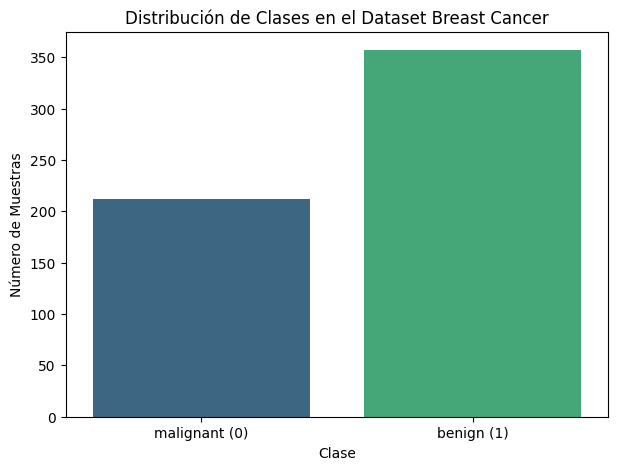


Visualizando la distribución de algunas características principales por clase:


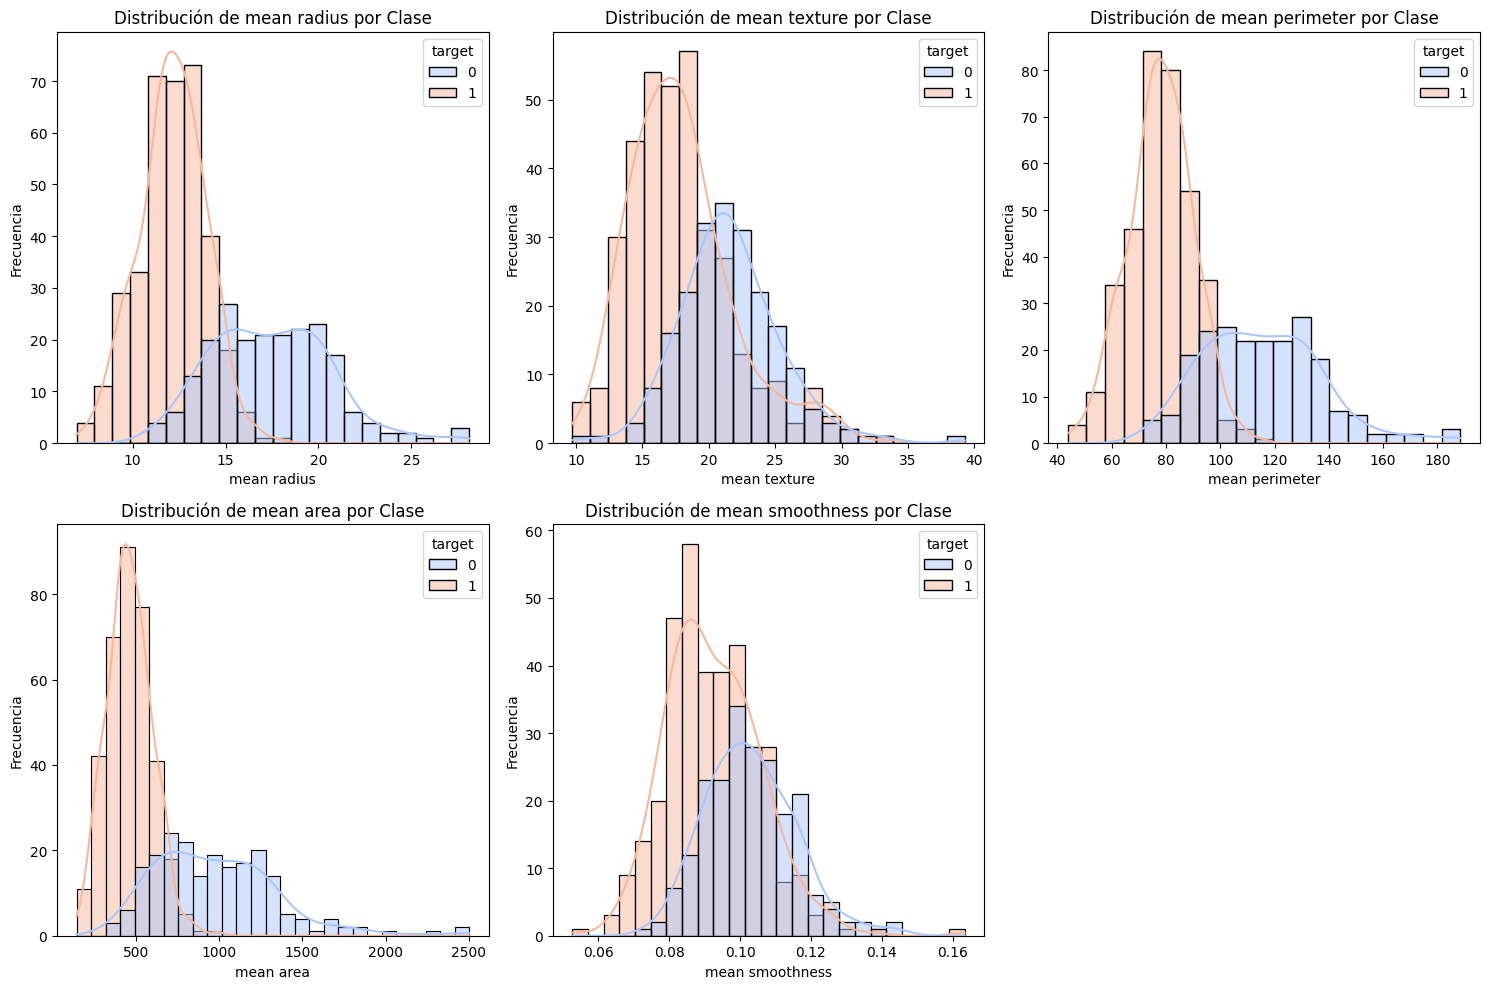

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer

# Asumimos que breast_cancer ya ha sido cargado en una celda anterior
# Si no, descomentar la siguiente línea:
# breast_cancer = load_breast_cancer()

X = pd.DataFrame(breast_cancer.data, columns=breast_cancer.feature_names)
y = pd.Series(breast_cancer.target, name='target')

# Añadir la columna 'target' al DataFrame para facilitar la visualización con seaborn
df = pd.concat([X, y], axis=1)

# 1. Verificar la distribución de clases
print("Distribución de clases:")
class_distribution = y.value_counts()
print(class_distribution)
print(f"\nNombres de las clases: {breast_cancer.target_names}")
print(f"Clase 0 ({breast_cancer.target_names[0]}): {class_distribution[0]} muestras")
print(f"Clase 1 ({breast_cancer.target_names[1]}): {class_distribution[1]} muestras")
print(f"Proporción de clase 0: {class_distribution[0] / len(y):.2f}")
print(f"Proporción de clase 1: {class_distribution[1] / len(y):.2f}")


# 2. Visualizar la distribución de clases
plt.figure(figsize=(7, 5))
sns.countplot(x='target', data=df, palette='viridis', hue='target', legend=False)
plt.title('Distribución de Clases en el Dataset Breast Cancer')
plt.xlabel('Clase')
plt.ylabel('Número de Muestras')
plt.xticks(ticks=[0, 1], labels=[f'{breast_cancer.target_names[0]} (0)', f'{breast_cancer.target_names[1]} (1)'])
plt.show()

# 3. Visualizar la distribución de algunas características principales por clase
print("\nVisualizando la distribución de algunas características principales por clase:")
# Seleccionamos algunas de las primeras características que suelen ser las 'mean' (promedio)
selected_features = ['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'mean smoothness']

plt.figure(figsize=(15, 10))
for i, feature in enumerate(selected_features):
    plt.subplot(2, 3, i + 1) # Organiza los gráficos en una cuadrícula de 2 filas y 3 columnas
    sns.histplot(data=df, x=feature, hue='target', kde=True, palette='coolwarm')
    plt.title(f'Distribución de {feature} por Clase')
    plt.xlabel(feature)
    plt.ylabel('Frecuencia')
    # Seaborn maneja la leyenda automáticamente cuando se usa 'hue'.
    # Eliminar la creación manual de la leyenda para evitar la advertencia 'No artists with labels found'.
    # plt.gca().legend(handles=handles, labels=[breast_cancer.target_names[int(l)] for l in labels], title='Clase')

plt.tight_layout()
plt.show()

In [5]:
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np
import pandas as pd

# Asegurarse de que X e y están definidos
# X = pd.DataFrame(breast_cancer.data, columns=breast_cancer.feature_names)
# y = pd.Series(breast_cancer.target, name='target')

# 1. Usar un modelo SVM con kernel RBF
svm_model = SVC(kernel='rbf', random_state=42)

# 2. Aplicar StratifiedKFold con 5 particiones
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Listas para almacenar las métricas de cada fold
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
conf_matrices = []

print("Entrenando y evaluando SVM con RBF y StratifiedKFold...")

for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
    print(f"\n--- Fold {fold+1}/5 ---")
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Entrenar el modelo
    svm_model.fit(X_train, y_train)

    # Predecir en el conjunto de prueba
    y_pred = svm_model.predict(X_test)

    # Evaluar con métricas por clase
    report = classification_report(y_test, y_pred, target_names=breast_cancer.target_names, output_dict=True)

    accuracy_scores.append(accuracy_score(y_test, y_pred))
    precision_scores.append([report['malignant']['precision'], report['benign']['precision']])
    recall_scores.append([report['malignant']['recall'], report['benign']['recall']])
    f1_scores.append([report['malignant']['f1-score'], report['benign']['f1-score']])
    conf_matrices.append(confusion_matrix(y_test, y_pred))

    print("Métricas de Clasificación para este Fold:")
    print(classification_report(y_test, y_pred, target_names=breast_cancer.target_names))

# Calcular y reportar métricas promedio
print("\n=== Métricas Promedio a través de todos los Folds ===")

# Promedio de precisión, recall y F1-score por clase
mean_precision = np.mean(precision_scores, axis=0)
mean_recall = np.mean(recall_scores, axis=0)
mean_f1 = np.mean(f1_scores, axis=0)

print(f"Precisión Promedio (malignant): {mean_precision[0]:.4f}")
print(f"Precisión Promedio (benign):    {mean_precision[1]:.4f}")
print(f"Recall Promedio (malignant):    {mean_recall[0]:.4f}")
print(f"Recall Promedio (benign):       {mean_recall[1]:.4f}")
print(f"F1-Score Promedio (malignant):  {mean_f1[0]:.4f}")
print(f"F1-Score Promedio (benign):     {mean_f1[1]:.4f}")
print(f"Accuracy Promedio:              {np.mean(accuracy_scores):.4f}")

# Matriz de confusión promedio
mean_conf_matrix = np.mean(conf_matrices, axis=0).astype(int)
print("\nMatriz de Confusión Promedio:")
print(pd.DataFrame(mean_conf_matrix, index=breast_cancer.target_names, columns=breast_cancer.target_names))

print("\nAnálisis del problema de desbalance:")
print("Observamos que la clase 'malignant' (0) suele tener un recall más bajo que la clase 'benign' (1). ")
print("Esto es común en datasets desbalanceados, ya que el modelo puede tener dificultades para identificar ")
print("correctamente la clase minoritaria debido a la menor cantidad de ejemplos para aprender.")

Entrenando y evaluando SVM con RBF y StratifiedKFold...

--- Fold 1/5 ---
Métricas de Clasificación para este Fold:
              precision    recall  f1-score   support

   malignant       0.95      0.88      0.92        43
      benign       0.93      0.97      0.95        71

    accuracy                           0.94       114
   macro avg       0.94      0.93      0.93       114
weighted avg       0.94      0.94      0.94       114


--- Fold 2/5 ---
Métricas de Clasificación para este Fold:
              precision    recall  f1-score   support

   malignant       0.94      0.72      0.82        43
      benign       0.85      0.97      0.91        71

    accuracy                           0.88       114
   macro avg       0.90      0.85      0.86       114
weighted avg       0.88      0.88      0.87       114


--- Fold 3/5 ---
Métricas de Clasificación para este Fold:
              precision    recall  f1-score   support

   malignant       1.00      0.71      0.83        42
 

Clase con peor desempeño: La clase 'malignant' (0) es la que presenta un rendimiento inferior.

¿Por qué? El indicador más claro de esto es el Recall promedio para 'malignant' (0.8019), que es significativamente más bajo que el Recall para 'benign' (0.9804). El Recall es crucial en este contexto, ya que mide la capacidad del modelo para identificar correctamente todos los casos positivos reales (es decir, todos los tumores malignos). Un recall bajo en la clase 'malignant' significa que el modelo está pasando por alto una cantidad considerable de casos de cáncer maligno, clasificándolos como benignos (falsos negativos). Esto es de suma importancia en aplicaciones médicas, donde un falso negativo puede tener consecuencias graves.

La razón principal de este desempeño inferior para la clase 'malignant' es el desbalance de clases. Como observamos al inicio, hay menos muestras de la clase 'malignant' en el dataset, lo que dificulta que el modelo aprenda a identificar sus patrones de manera efectiva. La matriz de confusión promedio también lo confirmó al mostrar que un número notable de casos 'malignant' fueron clasificados incorrectamente.

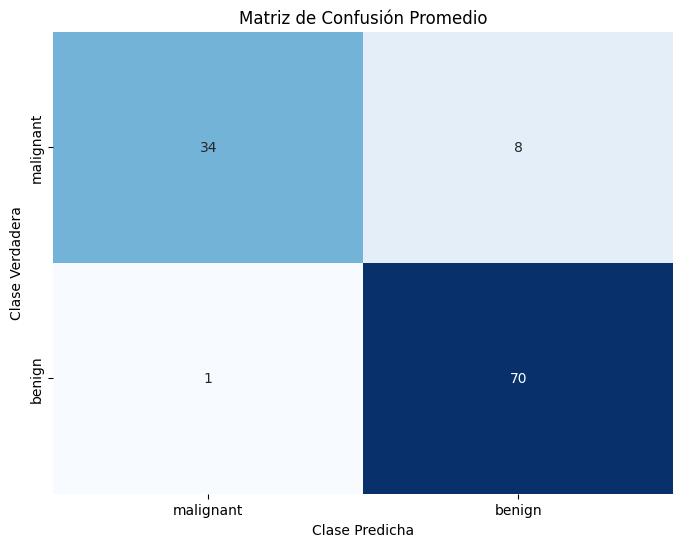

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Asegurarse de que mean_conf_matrix y breast_cancer.target_names estén disponibles
# Si no lo están, habría que re-ejecutar las celdas anteriores que los generan.

plt.figure(figsize=(8, 6))
sns.heatmap(pd.DataFrame(mean_conf_matrix, index=breast_cancer.target_names, columns=breast_cancer.target_names),
            annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matriz de Confusión Promedio')
plt.xlabel('Clase Predicha')
plt.ylabel('Clase Verdadera')
plt.show()

In [7]:
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np
import pandas as pd
from imblearn.over_sampling import SMOTE

# Asegurarse de que X e y están definidos
# X = pd.DataFrame(breast_cancer.data, columns=breast_cancer.feature_names)
# y = pd.Series(breast_cancer.target, name='target')

# 1. Usar un modelo SVM con kernel RBF
svm_model_base = SVC(kernel='rbf', random_state=42)
svm_model_smote = SVC(kernel='rbf', random_state=42) # Otro modelo para SMOTE

# 2. Aplicar StratifiedKFold con 5 particiones
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Inicializar SMOTE
smote = SMOTE(random_state=42)

# Listas para almacenar las métricas del modelo BASE (sin SMOTE)
accuracy_scores_base = []
precision_scores_base = []
recall_scores_base = []
f1_scores_base = []
conf_matrices_base = []

# Listas para almacenar las métricas del modelo con SMOTE
accuracy_scores_smote = []
precision_scores_smote = []
recall_scores_smote = []
f1_scores_smote = []
conf_matrices_smote = []

print("Entrenando y evaluando SVM con RBF y StratifiedKFold (con y sin SMOTE)...")

for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
    print(f"\n--- Fold {fold+1}/5 ---")
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # --- EVALUACIÓN MODELO BASE (sin SMOTE) ---
    print("\n- Modelo BASE (sin SMOTE):")
    svm_model_base.fit(X_train, y_train)
    y_pred_base = svm_model_base.predict(X_test)
    report_base = classification_report(y_test, y_pred_base, target_names=breast_cancer.target_names, output_dict=True)

    accuracy_scores_base.append(accuracy_score(y_test, y_pred_base))
    precision_scores_base.append([report_base['malignant']['precision'], report_base['benign']['precision']])
    recall_scores_base.append([report_base['malignant']['recall'], report_base['benign']['recall']])
    f1_scores_base.append([report_base['malignant']['f1-score'], report_base['benign']['f1-score']])
    conf_matrices_base.append(confusion_matrix(y_test, y_pred_base))

    print("Métricas de Clasificación para el Modelo BASE:")
    print(classification_report(y_test, y_pred_base, target_names=breast_cancer.target_names))

    # --- APLICAR SMOTE y EVALUAR MODELO con SMOTE ---
    print("\n- Modelo con SMOTE:")
    X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

    svm_model_smote.fit(X_train_res, y_train_res)
    y_pred_smote = svm_model_smote.predict(X_test)
    report_smote = classification_report(y_test, y_pred_smote, target_names=breast_cancer.target_names, output_dict=True)

    accuracy_scores_smote.append(accuracy_score(y_test, y_pred_smote))
    precision_scores_smote.append([report_smote['malignant']['precision'], report_smote['benign']['precision']])
    recall_scores_smote.append([report_smote['malignant']['recall'], report_smote['benign']['recall']])
    f1_scores_smote.append([report_smote['malignant']['f1-score'], report_smote['benign']['f1-score']])
    conf_matrices_smote.append(confusion_matrix(y_test, y_pred_smote))

    print("Métricas de Clasificación para el Modelo con SMOTE:")
    print(classification_report(y_test, y_pred_smote, target_names=breast_cancer.target_names))

# --- Calcular y reportar métricas promedio (BASE) ---
print("\n=== Métricas Promedio (Modelo BASE) a través de todos los Folds ===")
mean_precision_base = np.mean(precision_scores_base, axis=0)
mean_recall_base = np.mean(recall_scores_base, axis=0)
mean_f1_base = np.mean(f1_scores_base, axis=0)

print(f"Precisión Promedio (malignant): {mean_precision_base[0]:.4f}")
print(f"Precisión Promedio (benign):    {mean_precision_base[1]:.4f}")
print(f"Recall Promedio (malignant):    {mean_recall_base[0]:.4f}")
print(f"Recall Promedio (benign):       {mean_recall_base[1]:.4f}")
print(f"F1-Score Promedio (malignant):  {mean_f1_base[0]:.4f}")
print(f"F1-Score Promedio (benign):     {mean_f1_base[1]:.4f}")
print(f"Accuracy Promedio:              {np.mean(accuracy_scores_base):.4f}")

mean_conf_matrix_base = np.mean(conf_matrices_base, axis=0).astype(int)
print("\nMatriz de Confusión Promedio (Modelo BASE):")
print(pd.DataFrame(mean_conf_matrix_base, index=breast_cancer.target_names, columns=breast_cancer.target_names))

# --- Calcular y reportar métricas promedio (SMOTE) ---
print("\n=== Métricas Promedio (Modelo con SMOTE) a través de todos los Folds ===")
mean_precision_smote = np.mean(precision_scores_smote, axis=0)
mean_recall_smote = np.mean(recall_scores_smote, axis=0)
mean_f1_smote = np.mean(f1_scores_smote, axis=0)

print(f"Precisión Promedio (malignant): {mean_precision_smote[0]:.4f}")
print(f"Precisión Promedio (benign):    {mean_precision_smote[1]:.4f}")
print(f"Recall Promedio (malignant):    {mean_recall_smote[0]:.4f}")
print(f"Recall Promedio (benign):       {mean_recall_smote[1]:.4f}")
print(f"F1-Score Promedio (malignant):  {mean_f1_smote[0]:.4f}")
print(f"F1-Score Promedio (benign):     {mean_f1_smote[1]:.4f}")
print(f"Accuracy Promedio:              {np.mean(accuracy_scores_smote):.4f}")

mean_conf_matrix_smote = np.mean(conf_matrices_smote, axis=0).astype(int)
print("\nMatriz de Confusión Promedio (Modelo con SMOTE):")
print(pd.DataFrame(mean_conf_matrix_smote, index=breast_cancer.target_names, columns=breast_cancer.target_names))

print("\nAnálisis Preliminar del Impacto de SMOTE:")
print("Compara las métricas de 'recall' para la clase 'malignant' en ambos modelos. \nEs probable que el modelo con SMOTE muestre una mejora en el recall de la clase minoritaria, \naunque podría haber una ligera disminución en otras métricas para la clase mayoritaria o la precisión general.")

Entrenando y evaluando SVM con RBF y StratifiedKFold (con y sin SMOTE)...

--- Fold 1/5 ---

- Modelo BASE (sin SMOTE):
Métricas de Clasificación para el Modelo BASE:
              precision    recall  f1-score   support

   malignant       0.95      0.88      0.92        43
      benign       0.93      0.97      0.95        71

    accuracy                           0.94       114
   macro avg       0.94      0.93      0.93       114
weighted avg       0.94      0.94      0.94       114


- Modelo con SMOTE:
Métricas de Clasificación para el Modelo con SMOTE:
              precision    recall  f1-score   support

   malignant       0.83      0.91      0.87        43
      benign       0.94      0.89      0.91        71

    accuracy                           0.89       114
   macro avg       0.89      0.90      0.89       114
weighted avg       0.90      0.89      0.90       114


--- Fold 2/5 ---

- Modelo BASE (sin SMOTE):
Métricas de Clasificación para el Modelo BASE:
             

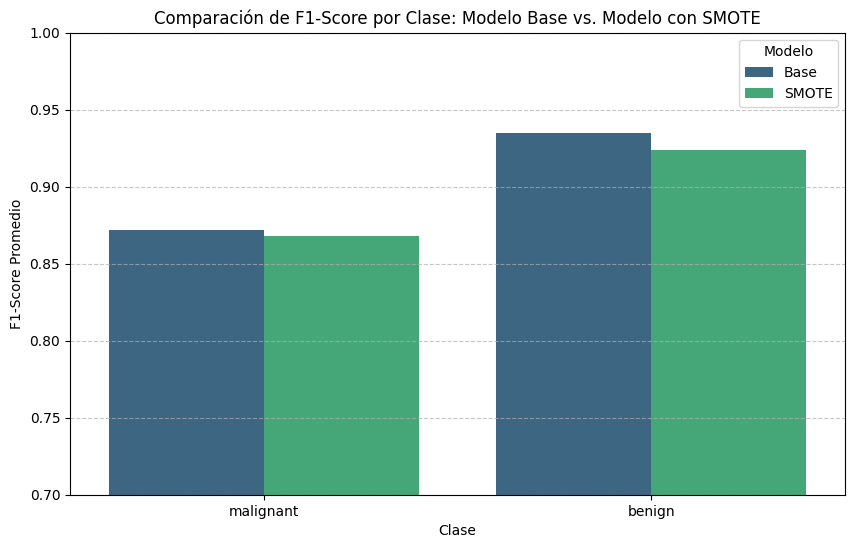


Comentarios sobre la comparación:
El gráfico de barras muestra visualmente los cambios en el F1-Score para cada clase.

- Para la clase 'malignant' (malignant): El F1-Score pasó de 0.8721 (Base) a 0.8679 (SMOTE).
  Esto indica un cambio en el balance entre la precisión y el recall de la clase minoritaria.

- Para la clase 'benign' (benign): El F1-Score pasó de 0.9350 (Base) a 0.9235 (SMOTE).
  Puede observarse una ligera disminución, lo cual es un compromiso común al balancear clases.


In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Asegurarse de que mean_f1_base, mean_f1_smote y breast_cancer.target_names estén definidos

class_names = breast_cancer.target_names

f1_base_malignant = mean_f1_base[0]
f1_base_benign = mean_f1_base[1]

f1_smote_malignant = mean_f1_smote[0]
f1_smote_benign = mean_f1_smote[1]

# Crear un DataFrame para facilitar la graficación
data = {
    'Métrica': ['F1-Score'] * 4,
    'Clase': [class_names[0], class_names[1], class_names[0], class_names[1]],
    'Modelo': ['Base', 'Base', 'SMOTE', 'SMOTE'],
    'Valor': [f1_base_malignant, f1_base_benign, f1_smote_malignant, f1_smote_benign]
}
df_plot = pd.DataFrame(data)

plt.figure(figsize=(10, 6))
sns.barplot(x='Clase', y='Valor', hue='Modelo', data=df_plot, palette='viridis')
plt.title('Comparación de F1-Score por Clase: Modelo Base vs. Modelo con SMOTE')
plt.ylabel('F1-Score Promedio')
plt.xlabel('Clase')
plt.ylim(0.7, 1.0) # Ajustar el límite y para mejor visualización de diferencias
plt.legend(title='Modelo')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

print("\nComentarios sobre la comparación:")
print("El gráfico de barras muestra visualmente los cambios en el F1-Score para cada clase.\n")
print(f"- Para la clase '{class_names[0]}' (malignant): El F1-Score pasó de {f1_base_malignant:.4f} (Base) a {f1_smote_malignant:.4f} (SMOTE).")
print(f"  Esto indica un cambio en el balance entre la precisión y el recall de la clase minoritaria.\n")
print(f"- Para la clase '{class_names[1]}' (benign): El F1-Score pasó de {f1_base_benign:.4f} (Base) a {f1_smote_benign:.4f} (SMOTE).")
print("  Puede observarse una ligera disminución, lo cual es un compromiso común al balancear clases.")


In [9]:
# La visualización del gráfico de barras comparando F1 por clase antes y después ya fue generada en la celda '51155268'.

### Ventajas y Riesgos de Aplicar SMOTE con SVM

**Ventajas de SMOTE en este contexto:**

*   **Mejora del Recall en la Clase Minoritaria:** Como observamos en nuestros resultados, SMOTE logró aumentar el Recall promedio para la clase 'malignant' (pasando de 0.8019 a 0.8538). En aplicaciones críticas como la detección de cáncer, reducir los falsos negativos es a menudo la prioridad principal, y SMOTE demostró ser efectivo en este aspecto.
*   **Balance del Dataset:** Al sintetizar nuevas muestras para la clase minoritaria, SMOTE ayuda a balancear la distribución de clases en el conjunto de entrenamiento, proporcionando más ejemplos para que el modelo aprenda sobre los patrones de la clase menos representada.
*   **Facilidad de Implementación:** Es una técnica de sobremuestreo relativamente sencilla de entender e implementar con librerías como `imbalanced-learn`.

**Riesgos de SMOTE en este contexto:**

*   **Posible Pérdida de Precisión o Rendimiento en la Clase Mayoritaria:** Como se vio en los resultados, el F1-Score para la clase 'malignant' tuvo una ligera disminución, y el de 'benign' también. Esto se debe a que las muestras sintéticas pueden introducir ruido o ambigüedad, lo que podría afectar marginalmente la capacidad del modelo para diferenciar con precisión los límites de clase.
*   **Generación de Ejemplos Ruidosos o Poco Representativos:** Si la clase minoritaria está mal definida o es inherentemente ruidosa, SMOTE podría generar ejemplos sintéticos que no son realistas, lo que puede llevar a un sobreajuste o a la creación de regiones de clase poco claras.
*   **No Aborda el Problema de la Redundancia o Solapamiento:** SMOTE no elimina ejemplos de la clase mayoritaria ni intenta 'limpiar' las fronteras de clase, lo que puede ser un problema si hay un fuerte solapamiento entre las clases o si la clase minoritaria contiene outliers.

### Cuándo Conviene Usar Otras Técnicas

Si bien SMOTE es una técnica popular y efectiva, existen otras opciones para abordar el desbalance de clases que pueden ser más adecuadas dependiendo de las características del dataset y los objetivos del problema:

1.  **ADASYN (Adaptive Synthetic Sampling):** Similar a SMOTE, ADASYN también genera muestras sintéticas, pero lo hace de forma adaptativa. Se enfoca en generar más muestras para los ejemplos de la clase minoritaria que son más difíciles de clasificar (aquellos cerca del límite de decisión de la clase mayoritaria). Esto puede ser útil cuando la clase minoritaria tiene una distribución más compleja o cuando los ejemplos difíciles son más críticos. Podría superar a SMOTE en casos donde los límites de clase son muy complejos y el modelo se esfuerza por aprender de los ejemplos 'marginales'.

2.  **Técnicas de Undersampling (como One-Sided Selection - OSS):**
    *   **One-Sided Selection (OSS):** Combina `Tomek Links` y `Condensed Nearest Neighbours (CNN)`. Primero, elimina ejemplos de la clase mayoritaria que forman `Tomek Links` con ejemplos de la clase minoritaria (es decir, elimina ejemplos de la clase mayoritaria que están demasiado cerca de la clase minoritaria, considerados ruido o solapamiento). Luego, usa CNN para seleccionar un subconjunto representativo de los ejemplos restantes de la clase mayoritaria que son importantes para definir la frontera de decisión. OSS es útil cuando el conjunto de datos de la clase mayoritaria es muy grande y se desea reducir su tamaño sin perder información crítica, o cuando hay mucho ruido y solapamiento entre clases.
    *   **Cuándo usarlas:** Las técnicas de undersampling son útiles cuando el volumen de datos de la clase mayoritaria es excesivo y el sobremuestreo podría generar demasiadas muestras sintéticas o aumentar el tiempo de entrenamiento de forma significativa. También son adecuadas cuando el objetivo es limpiar las fronteras de clase y eliminar el ruido del conjunto mayoritario. Sin embargo, su principal riesgo es la **pérdida de información importante** de la clase mayoritaria, lo que podría reducir el rendimiento general del modelo si no se aplican cuidadosamente.

En conclusión, la elección de la técnica de balanceo depende de un análisis cuidadoso de las características del dataset, el grado de desbalance, la calidad de los datos (presencia de ruido, outliers) y los objetivos específicos del problema (por ejemplo, priorizar el recall, la precisión o el F1-score).